# Problem 1

Consider a 2D robotic arm with 3 links. The position of its end-effector is governed by the arm lengths and joint angles as follows (as in the figure "data/robot-arm.png"):
$$
x = L_1 \cos(\theta_1) + L_2\cos(\theta_2+\theta_1) + L_3\cos(\theta_3+\theta_2+\theta_1)\\
y = L_1\sin(\theta_1) + L_2\sin(\theta_2+\theta_1) + L_3\sin(\theta_3+\theta_2+\theta_1)
$$

In robotics settings, inverse-kinematics problems are common for setups like this. For example, suppose all 3 arm lengths are $L_1 = L_2 = L_3 = 1$, and we want to position the end-effector at $(x,y) = (0.5, 0.5)$. What set of joint angles $(\theta_1, \theta_2, \theta_3)$ should we choose for the end-effector to reach this position?

In this problem you will train a neural network to find a function mapping from coordinates $(x,y)$ to joint angles $(\theta_1, \theta_2, \theta_3)$ that position the end-effector at $(x,y)$.



#### Summary of deliverables:

1. Neural network model

2. Generate training and validation data

3. Training function

4. 6 plots with training and validation loss

5. 6 prediction plots

6. Respond to the prompts


In [251]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F

class ForwardArm(nn.Module):
    def __init__(self, L1=1, L2=1, L3=1):
        super().__init__()
        self.L1 = L1
        self.L2 = L2
        self.L3 = L3
    def forward(self, angles):
        theta1 = angles[:,0]
        theta2 = angles[:,1]
        theta3 = angles[:,2]
        x = self.L1*torch.cos(theta1) + self.L2*torch.cos(theta1+theta2) + self.L3*torch.cos(theta1+theta2+theta3)
        y = self.L1*torch.sin(theta1) + self.L2*torch.sin(theta1+theta2) + self.L3*torch.sin(theta1+theta2+theta3)
        return torch.vstack([x,y]).T

def plot_predictions(model, title=""):
    fwd = ForwardArm()

    vals = np.arange(0.1, 2.0, 0.2)
    x, y = np.meshgrid(vals,vals)
    coords = torch.tensor(np.vstack([x.flatten(),y.flatten()]).T,dtype=torch.float)
    angles = model(coords)
    preds = fwd(angles).detach().numpy()

    plt.figure(figsize=[4,4],dpi=140)

    plt.scatter(x.flatten(), y.flatten(), s=60, c="None",marker="o",edgecolors="k", label="Targets")
    plt.scatter(preds[:,0], preds[:,1], s=25, c="red", marker="o", label="Predictions")
    plt.text(0.1, 2.15, f"MSE = {nn.MSELoss()(fwd(model(coords)),coords):.1e}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-.1,2.1)
    plt.ylim(-.1,2.4)
    plt.legend()
    plt.title(title)
    plt.show()

def plot_arm(theta1, theta2, theta3, L1=1,L2=1,L3=1, show=True):
    x1 = L1*np.cos(theta1)
    y1 = L1*np.sin(theta1)
    x2 = x1 + L2*np.cos(theta1+theta2)
    y2 = y1 + L2*np.sin(theta1+theta2)
    x3 = x2 + L3*np.cos(theta1+theta2+theta3)
    y3 = y2 + L3*np.sin(theta1+theta2+theta3)
    xs = np.array([0,x1,x2,x3])
    ys = np.array([0,y1,y2,y3])

    plt.figure(figsize=(5,5),dpi=140)
    plt.plot(xs, ys, linewidth=3, markersize=5,color="gray", markerfacecolor="lightgray",marker="o",markeredgecolor="black")
    plt.scatter(x3,y3,s=50,color="blue",marker="P",zorder=100)
    plt.scatter(0,0,s=50,color="black",marker="s",zorder=-100)
    
    plt.xlim(-1.5,3.5)
    plt.ylim(-1.5,3.5)

    if show:
        plt.show()

## End-effector position

You can use the interactive figure below to visualize the robot arm.

In [252]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, FloatSlider, Dropdown

def plot_unit_arm(theta1, theta2, theta3):
    plot_arm(theta1, theta2, theta3)

slider1 = FloatSlider(value=0, min=-np.pi*0.75, max=np.pi*0.75, step=np.pi/100, description='theta1',disabled=False,continuous_update=True,orientation='horizontal',readout=False,layout = Layout(width='550px'))
slider2 = FloatSlider(value=0, min=-np.pi*0.75, max=np.pi*0.75, step=np.pi/100, description='theta2',disabled=False,continuous_update=True,orientation='horizontal',readout=False,layout = Layout(width='550px'))
slider3 = FloatSlider(value=0, min=-np.pi*0.75, max=np.pi*0.75, step=np.pi/100, description='theta3',disabled=False,continuous_update=True,orientation='horizontal',readout=False,layout = Layout(width='550px'))

interactive_plot = interactive(plot_unit_arm, theta1 = slider1, theta2 = slider2, theta3 = slider3)
output = interactive_plot.children[-1]
output.layout.height = '600px'

interactive_plot

interactive(children=(FloatSlider(value=0.0, description='theta1', layout=Layout(width='550px'), max=2.3561944…

## Neural Network for Inverse Kinematics
In this class we have mainly had regression problems with only one output. However, you can create neural networks with any number of outputs just by changing the size of the last layer. For this problem, we already know the function to go from joint angles (3) to end-effector coordinates (2). This is provided in neural network format as `ForwardArm()`.

If you provide an instance of `ForwardArm()` with an $N\times3$ tensor of joint angles, and it will return an $N\times2$ tensor of coordinates.

Here, you should create a neural network with 2 inputs and 3 outputs that, once trained, can output the joint angles (in radians) necessary to reach the input x-y coordinates.

In the cell below, complete the definition for `InverseArm()`:
- The initialization argument `hidden_layer_sizes` dictates the number of neurons per hidden layer in the network. For example, `hidden_layer_sizes=[12,24]` should create a network with 2 inputs, 12 neurons in the first hidden layer, 24 neurons in the second hidden layer, and 3 outputs.
- Use a ReLU activation at the end of each hidden layer.
- The initialization argument `max_angle` refers to the maximum bend angle of the joint. If `max_angle=None`, there should be no activation at the last layer. However, if `max_angle=1` (for example), then the output joint angles should be restricted to the interval [-1, 1] (radians). You can clamp values with the tanh function (and then scale them) to achieve this.



In [253]:
class InverseArm(nn.Module):
    def __init__(self, hidden_layer_sizes=[24,24], max_angle=None):
        super().__init__()
        # YOUR CODE GOES HERE
        # 2 inputs, 3 outputs
        # 2 hidden layers, each with 24 neurons
        # ReLU activation at end of each hidden layer
        # max_angle clamp values with tanh function
        self.hidden_layers = nn.ModuleList()
        self.max_angle = max_angle

        input_size = 2
        output_size = 3

        for size in hidden_layer_sizes:
            self.hidden_layers.append(nn.Linear(input_size, size))
            input_size = size
        self.output_layer = nn.Linear(input_size, output_size)
        # self.output_layer = nn.Linear(hidden_layer_sizes[-1], 3)


    def forward(self, xy):
        # YOUR CODE GOES HERE
        x = xy
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
    
        if self.max_angle is not None:
            x = self.max_angle * torch.tanh(x)
        
        return x

## Generate Data

In the cell below, generate a dataset of x-y coordinates. You should use a $100\times 100$ meshgrid, for x and y each on the interval $[0, 2]$.  

Randomly split your data so that 80% of points are in `X_train`, while the remaining 20% are in `X_val`. (Each of these should have 2 columns -- x and y)

In [254]:
# YOUR CODE GOES HERE
# generate dataset with x-y coordinates (100 by 100 meshgrid, from 0 to 2)
# randomly split 80% of points are in X_train, 20% in X_val

# set up 100 by 100 meshgrid
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
x, y = np.meshgrid(x, y)
# flatten the meshgrid
xy = np.vstack([x.flatten(), y.flatten()]).T

# randomly split the data into 80 and 20
np.random.shuffle(xy)
split_data = int(0.8 * len(xy))
X_train, X_val = xy[:split_data], xy[split_data:]

# convert to tensor
X_train = torch.tensor(X_train, dtype=torch.float)
X_val = torch.tensor(X_val, dtype=torch.float)

# print for testing
# print ("xy shape:", xy.shape)
# print("X_train shape:", X_train.shape)
# print("X_val shape:", X_val.shape)

## Training function

Write a function `train()` below with the following specifications:

*Inputs:*  
- `model`: `InverseArm` model to train
- `X_train`: $N\times 2$ vector of training x-y coordinates
- `X_val`: $N\times 2$ vector of validation x-y coordinates
- `lr`: Learning rate for Adam optimizer
- `epochs`: Total epoch count
- `gamma`: ExponentialLR decay rate
- `create_plot`: (`True`/`False`) Whether to display a plot with training and validation loss curves

*Loss function:*  
The loss function you use should be based on whether the end-effector moves to the correct location. It should be the MSE between the target coordinate tensor and the coordinates that the predicted joint angles produce. In other words, if your inverse kinematics model is `model`, and `fwd` is an instance of `ForwardArm()`, then you want the MSE between input coordinates `X` and `fwd(model(X))`.


In [255]:
from torch.optim.lr_scheduler import ExponentialLR

def train(model, X_train, X_val, lr = 0.01, epochs = 1000, gamma = 1, create_plot = True):
    # YOUR CODE GOES HERE
    opt = optim.Adam(model.parameters(), lr=lr)
    sch = ExponentialLR(opt, gamma)

    # loss_fn = F.mse_loss()

    train_loss = []
    val_loss = []

    # training loop
    for epoch in range(epochs):
        model.train()
        opt.zero_grad()
        train_output = model(X_train)
        fwd = ForwardArm()
        train_pred = fwd(train_output)
        # loss = loss_fn(train_output, train_pred)
        # loss = F.mse_loss(train_pred, X_train)
        loss = F.mse_loss(X_train, train_pred)
        train_loss.append(loss.item())
        loss.backward()
        opt.step()

        # validation loop
        model.eval()
        with torch.no_grad():
            val_output= model(X_val)
            val_pred = fwd(val_output)
            # val_loss.append(F.mse_loss(val_pred, X_val).item())
            val_loss.append(F.mse_loss( X_val, val_pred).item())

        sch.step()

        # print loss progress info 25 times during training
        # if epoch % int(epochs//25) == 0:
        #     print(f"Epoch {epoch} of {epochs}... \tAverage loss: {loss.item()}")

        train_loss.append(loss.item())

    # plot the loss curves
    if create_plot:
        plt.figure(dpi=250)
        plt.plot(train_loss, label="Training Loss")
        plt.plot(val_loss, label="Validation Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.title(f"Loss Curves for Model with {len(model.hidden_layers)} hidden layers")
        plt.legend()
        plt.show()

    return

## Training a model

Create 3 models of different complexities (with `max_angle=None`):
- `hidden_layer_sizes=[12]`
- `hidden_layer_sizes=[24,24]`
- `hidden_layer_sizes=[48,48,48]`

Train each model for 1000 epochs, learning rate 0.01, and gamma 0.995. Show the plot for each.

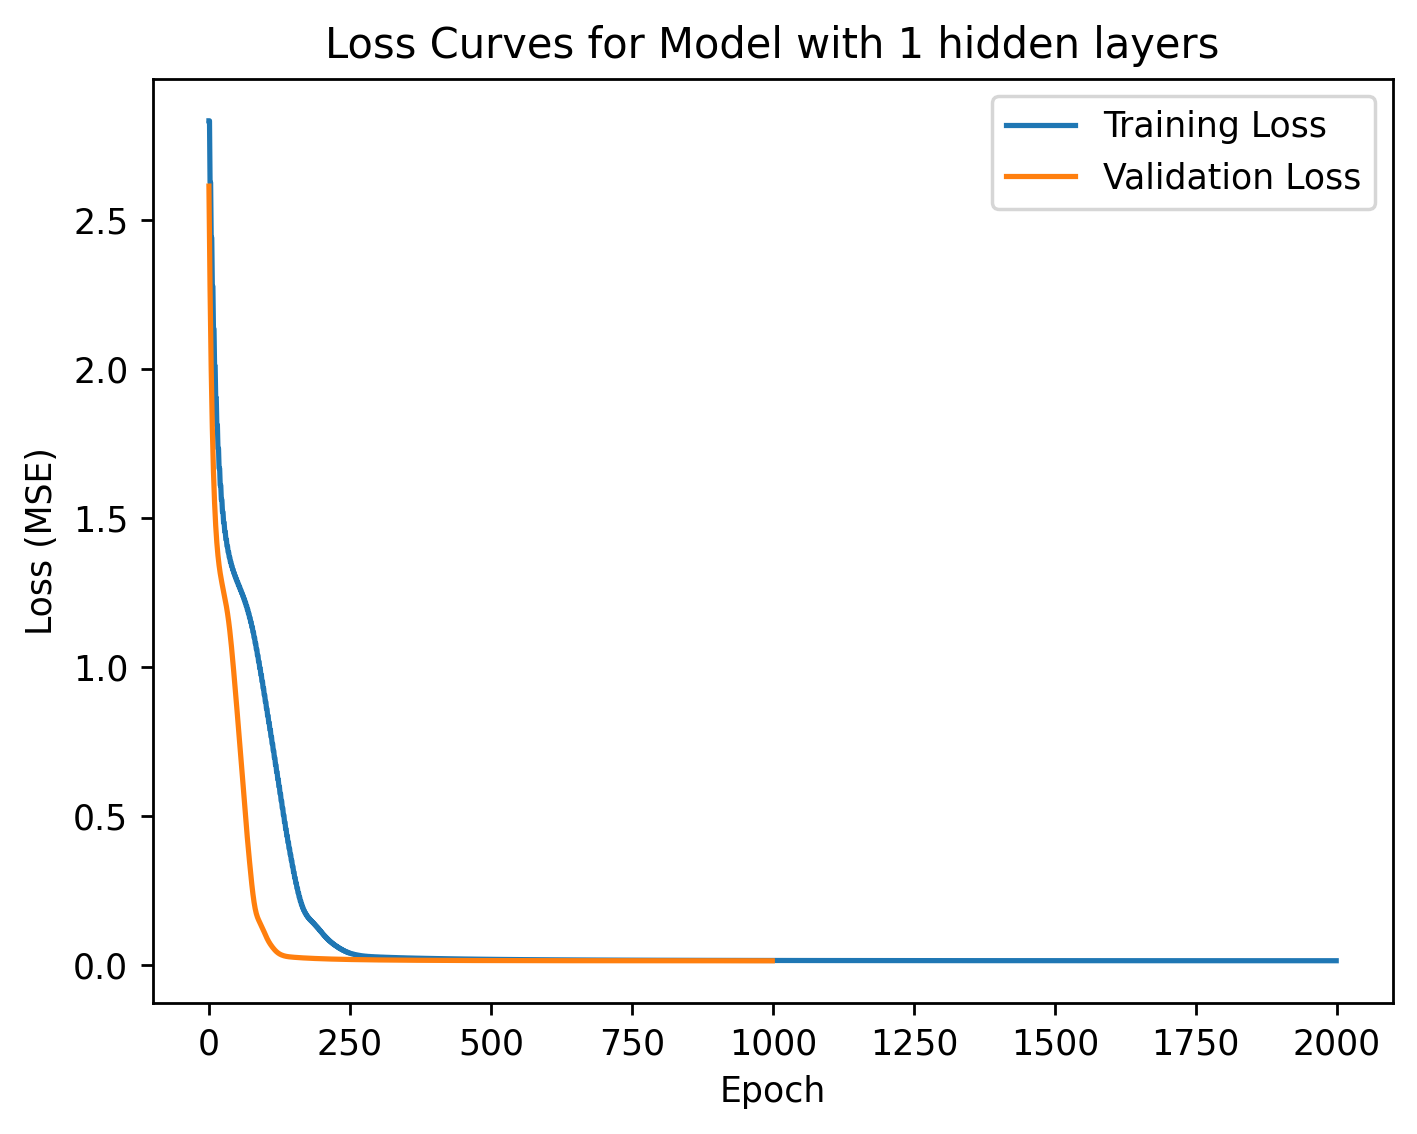

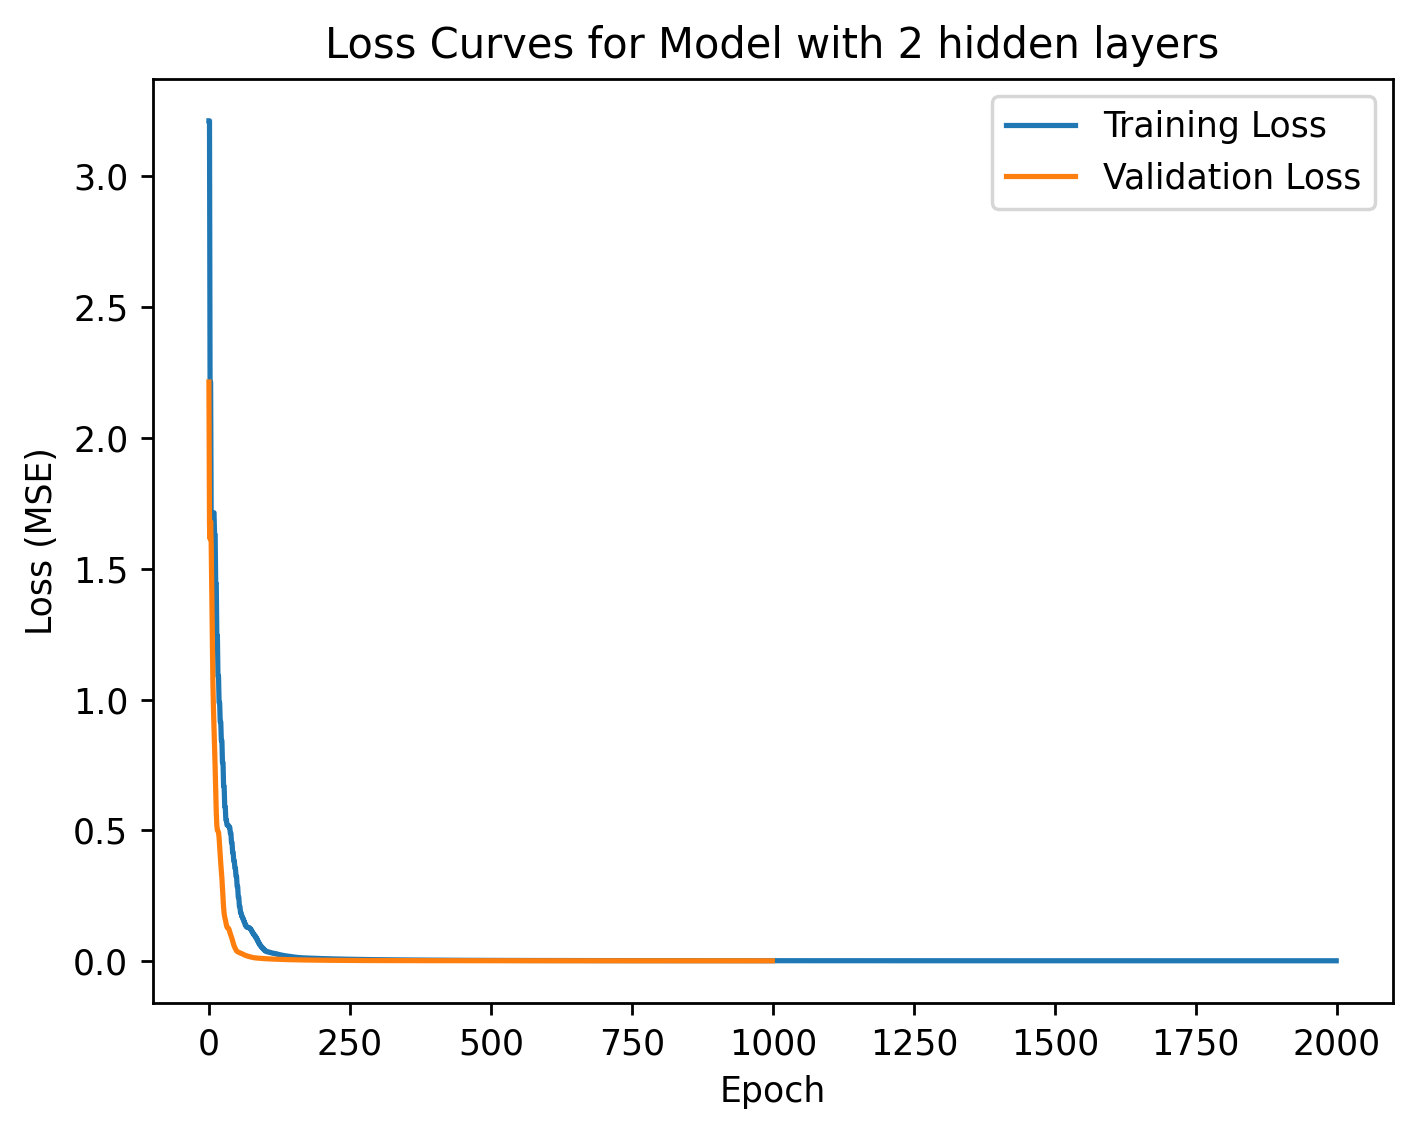

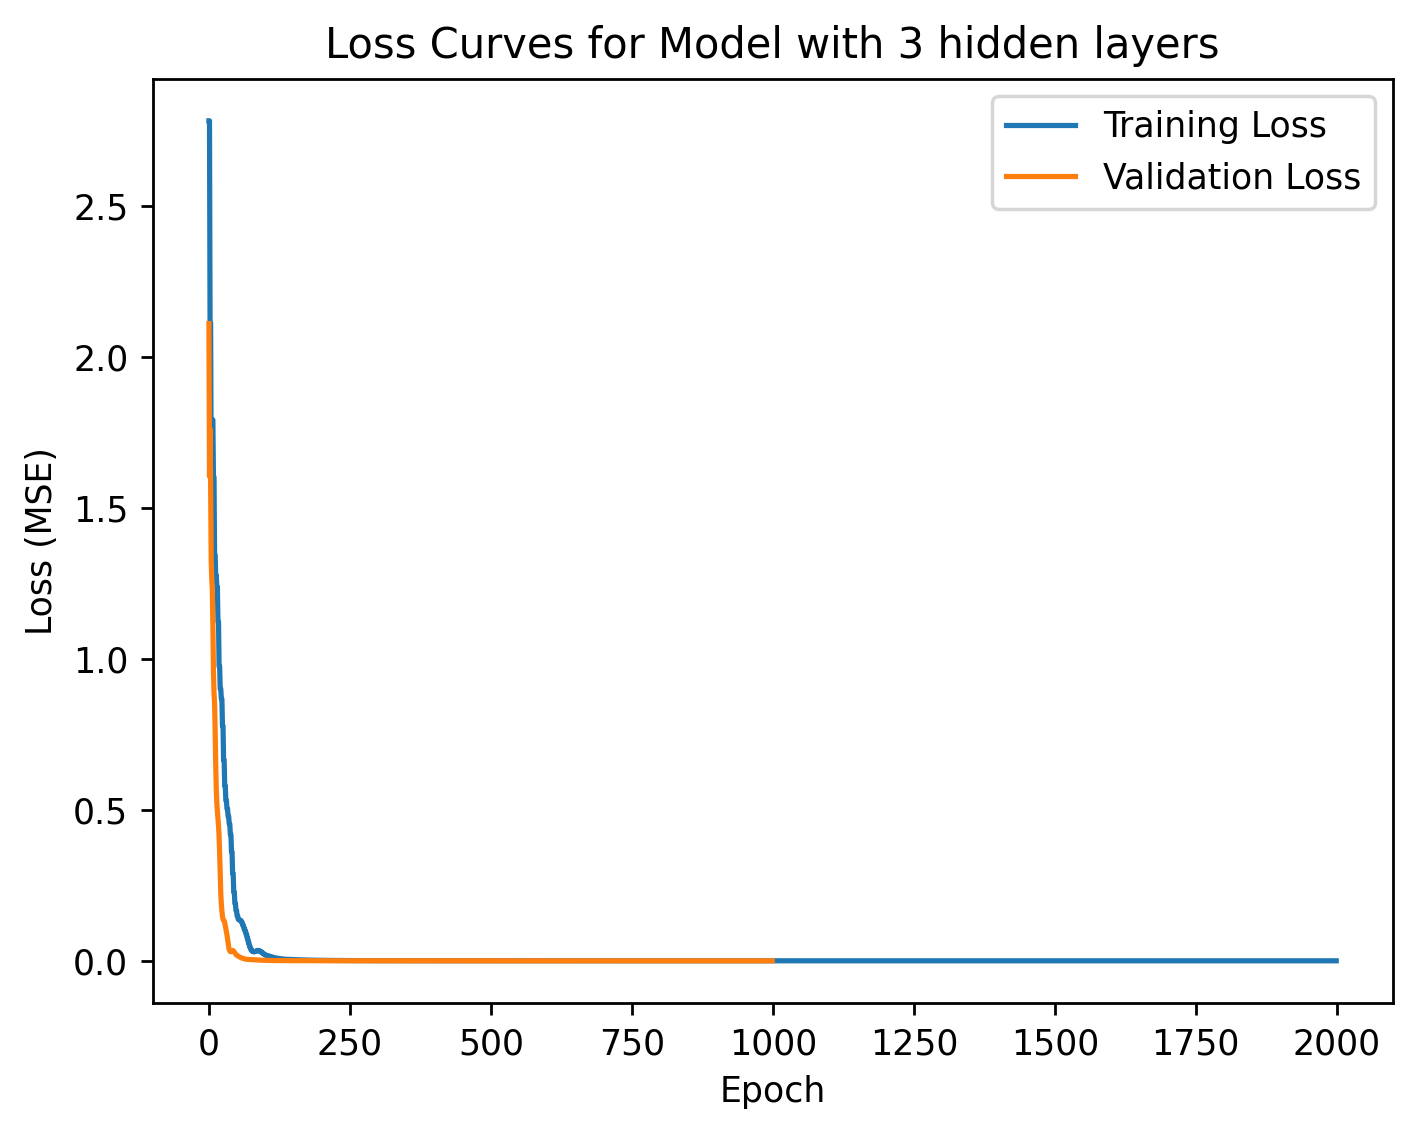

In [256]:
# YOUR CODE GOES HERE
# 1000 epochs, learning rate 0.01, gamma 0.995, and show plot 

# model 1 (hidden_layer_sizes=[12], max_angle=None)
model1 = InverseArm(hidden_layer_sizes=[12], max_angle=None)
train(model1, X_train, X_val, lr=0.01, epochs=1000, gamma=0.995, create_plot=True)

# model 2 (hidden_layer_sizes=[24,24], max_angle=None)
model2 = InverseArm(hidden_layer_sizes=[24,24], max_angle=None)
train(model2, X_train, X_val, lr=0.01, epochs=1000, gamma=0.995, create_plot=True)

# model 3 (hidden_layer_sizes=[48, 48, 48], max_angle=None)
model3 = InverseArm(hidden_layer_sizes=[48,48,48], max_angle=None)
train(model3, X_train, X_val, lr=0.01, epochs=1000, gamma=0.995, create_plot=True)

## Visualizations

For each of your models, use the function `plot_predictions` to visualize model predictions on the domain. You should observe improvements with increasing network size.

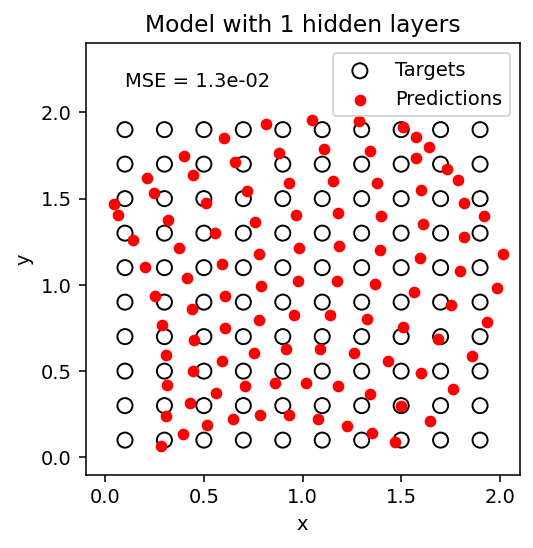

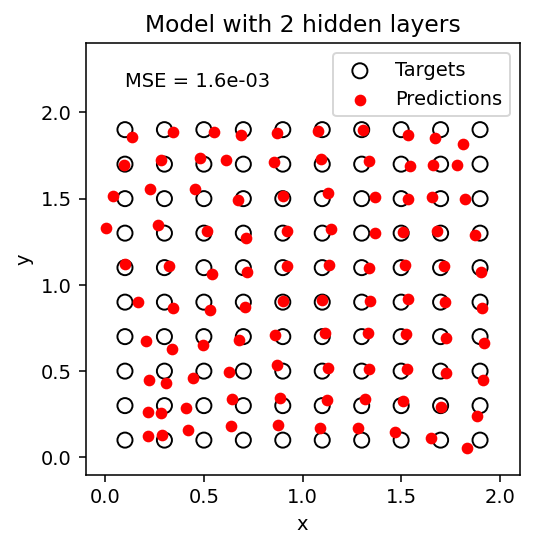

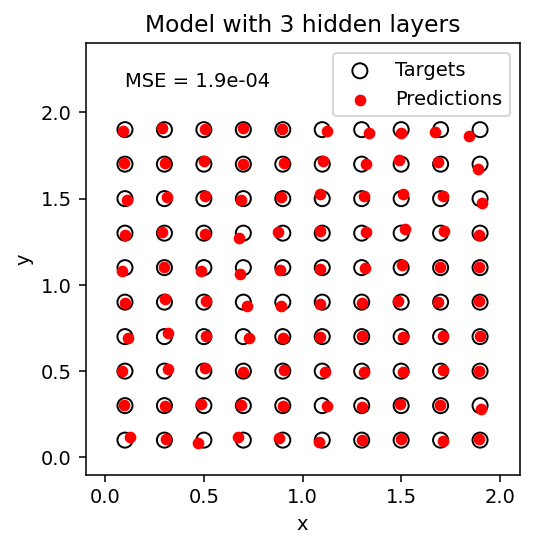

In [257]:
# YOUR CODE GOES HERE
# plot the predictions for each model
for model in [model1, model2, model3]:
    plot_predictions(model, title=f"Model with {len(model.hidden_layers)} hidden layers")

## Interactive Visualization


You can use the interactive plot below to look at the performance of your model. (The model used must be named `model`.)

In [258]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, FloatSlider, Dropdown

def plot_inverse(x, y):
    xy = torch.Tensor([[x,y]])
    theta1, theta2, theta3 = model(xy).detach().numpy().flatten().tolist()
    plot_arm(theta1, theta2, theta3, show=False)
    plt.scatter(x, y, s=100, c="red",zorder=1000,marker="x")
    plt.plot([0,2,2,0,0],[0,0,2,2,0],c="lightgray",linewidth=1,zorder=-1000)
    plt.show()

slider1 = FloatSlider(value=1, min=-.5, max=2.5, step=1/100, description='x', disabled=False, continuous_update=True, orientation='horizontal', readout=False, layout = Layout(width='550px'))
slider2 = FloatSlider(value=1, min=-.5, max=2.5, step=1/100, description='y', disabled=False, continuous_update=True, orientation='horizontal', readout=False, layout = Layout(width='550px'))

interactive_plot = interactive(plot_inverse, x = slider1, y = slider2)
output = interactive_plot.children[-1]
output.layout.height = '600px'

interactive_plot

interactive(children=(FloatSlider(value=1.0, description='x', layout=Layout(width='550px'), max=2.5, min=-0.5,…

## Training more neural networks

Now train more networks with the following details:
1. `hidden_layer_sizes=[48,48], max_angle=torch.pi/2`, train with `lr=0.01, epochs=1000, gamma=.995`
2. `hidden_layer_sizes=[48,48], max_angle=None`, train with `lr=1, epochs=1000, gamma=1`
3. `hidden_layer_sizes=[48,48], max_angle=2`, train with `lr=0.0001, epochs=300, gamma=1`

For each network, show a loss curve plot and a `plot_predictions` plot.

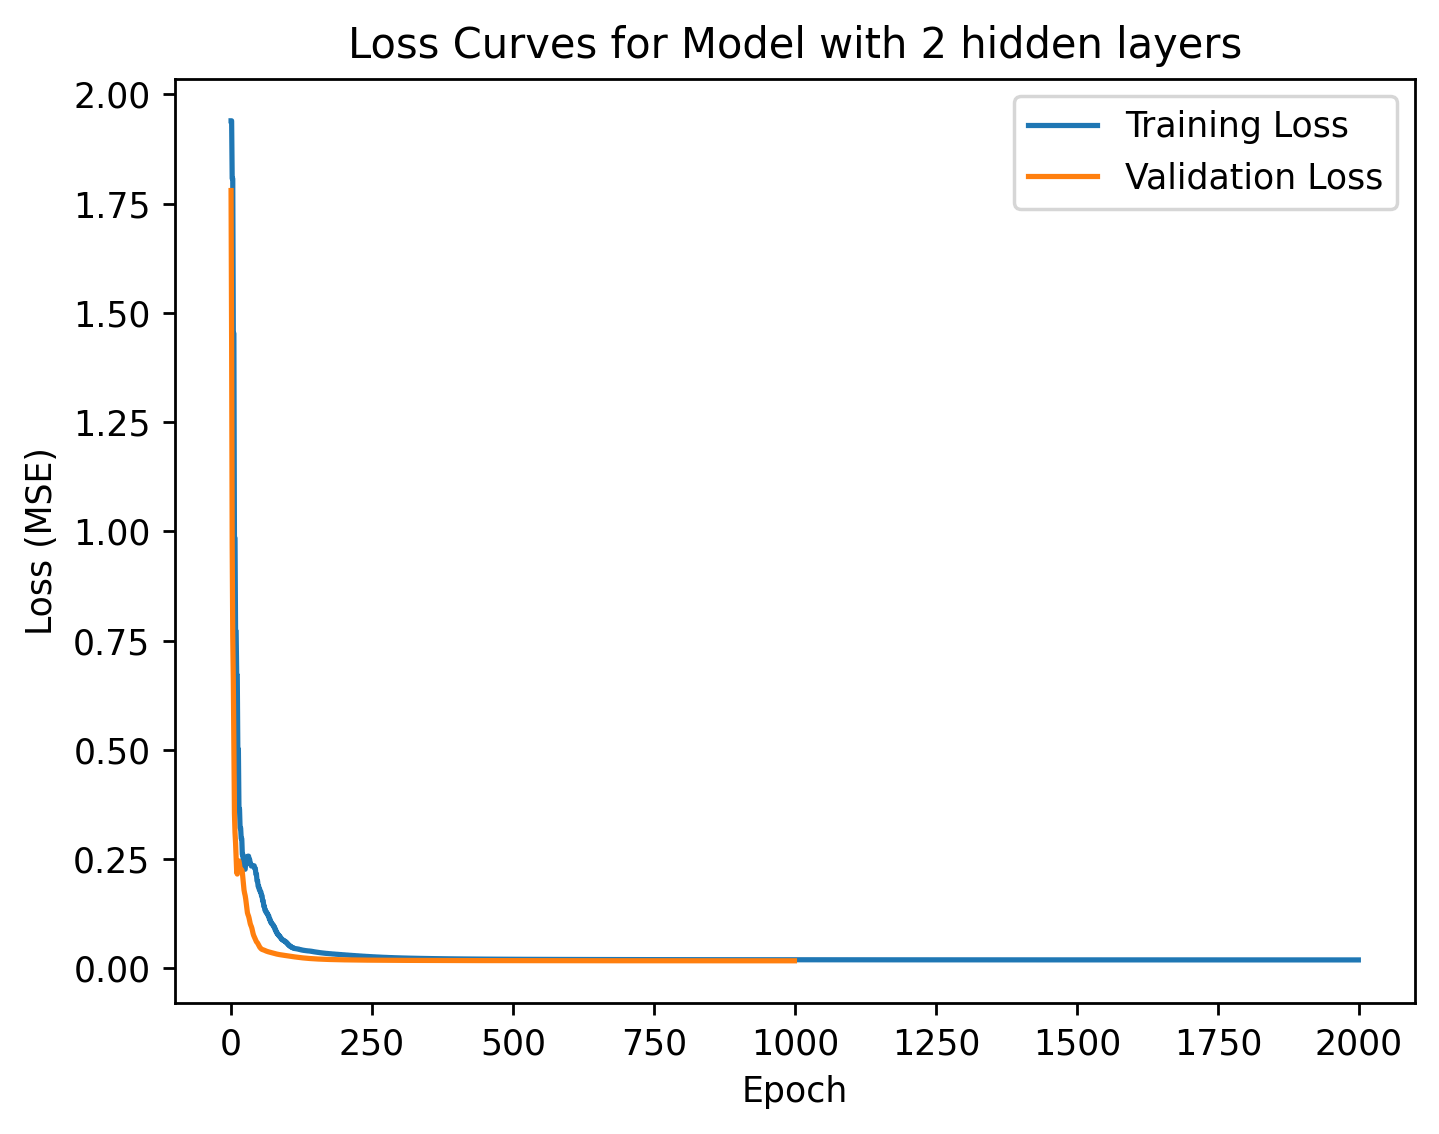

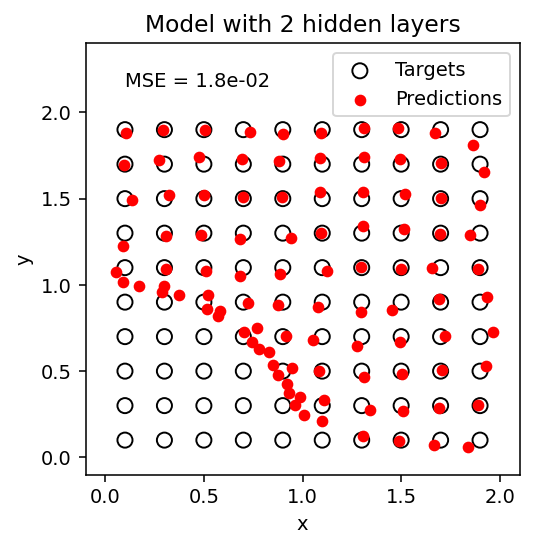

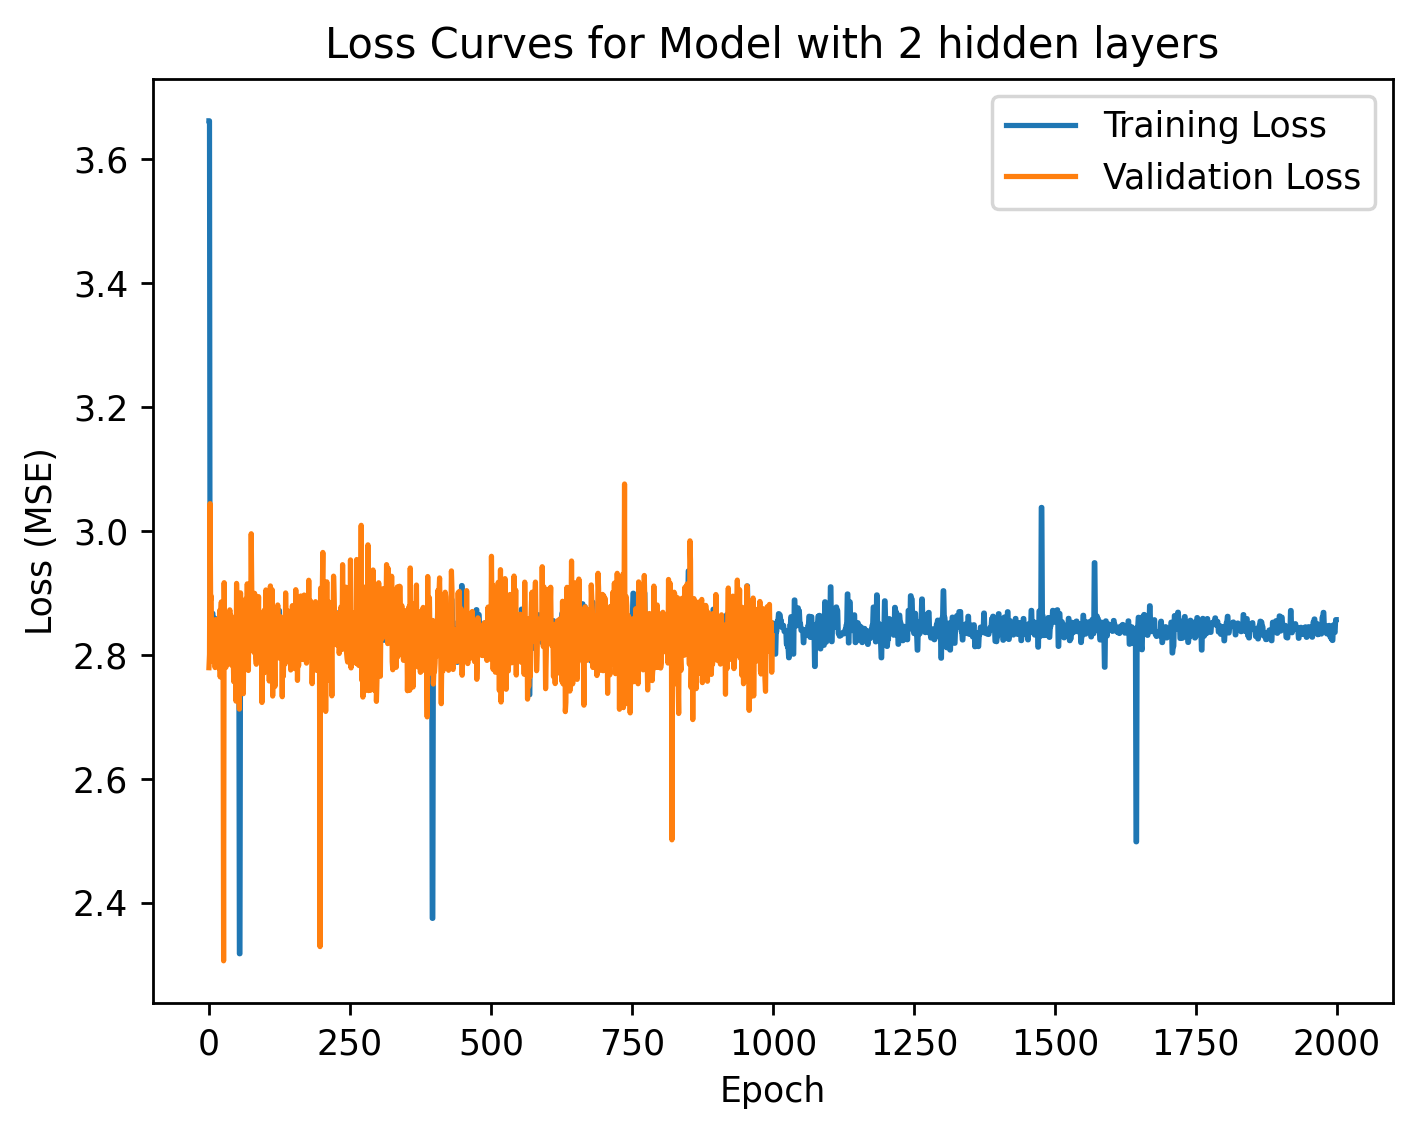

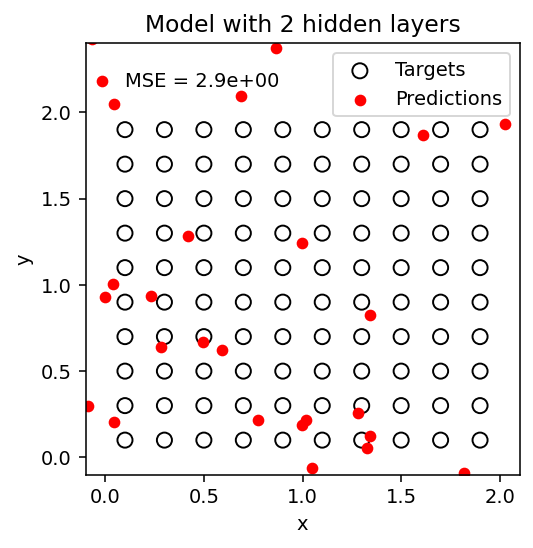

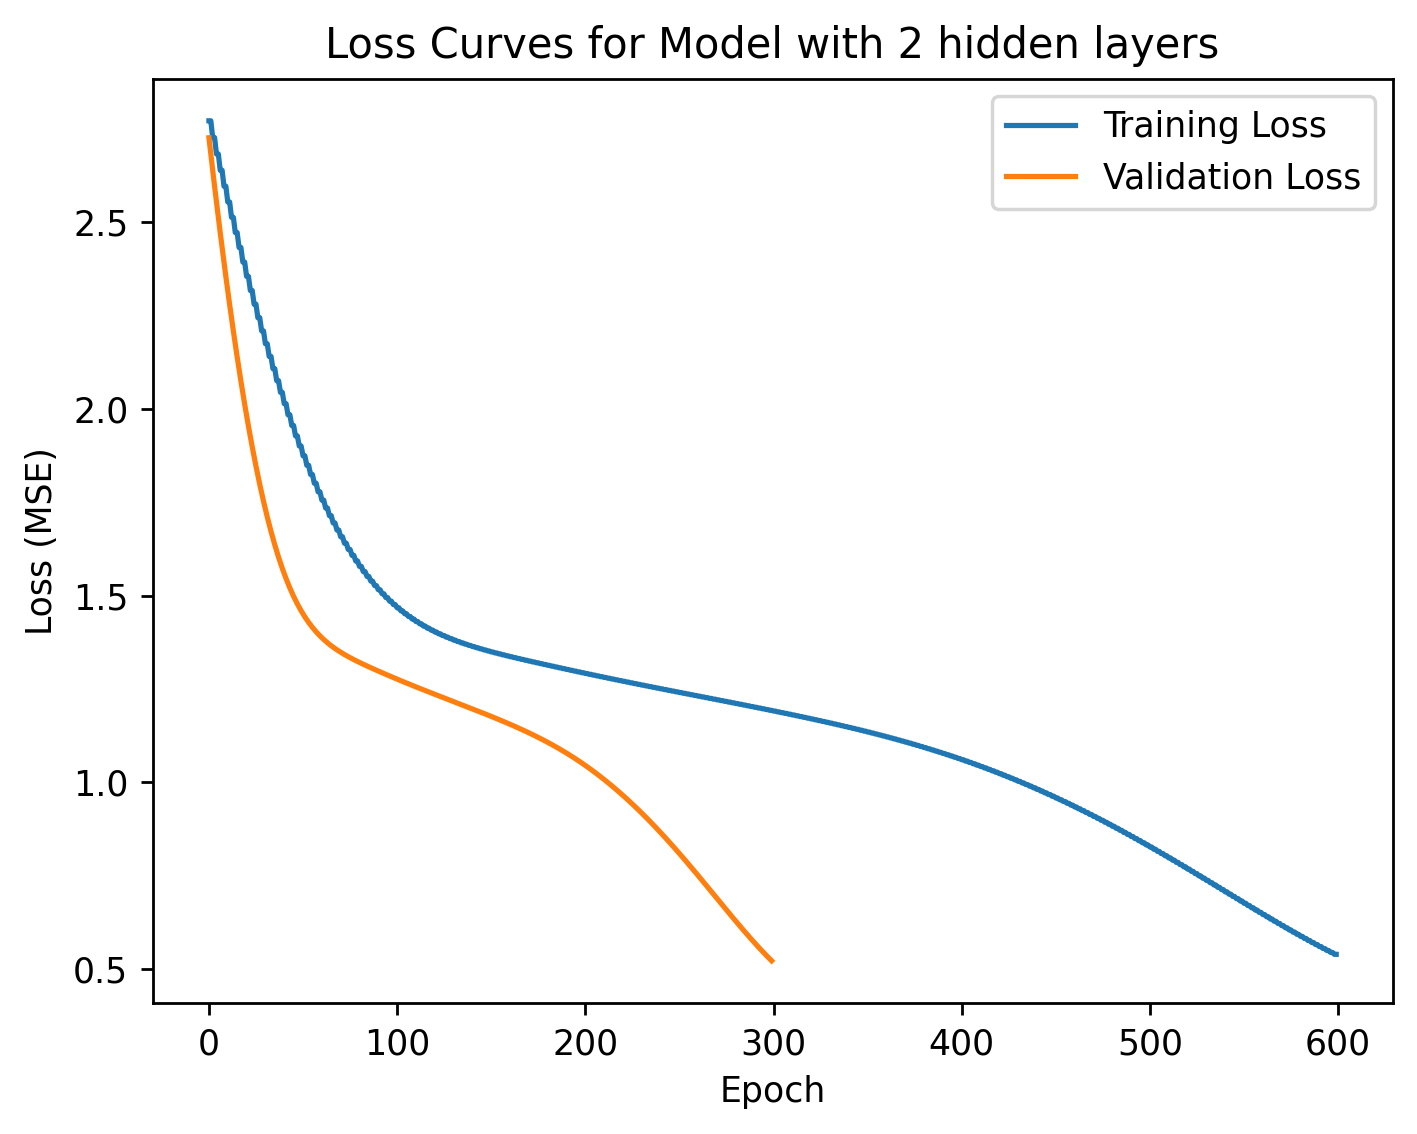

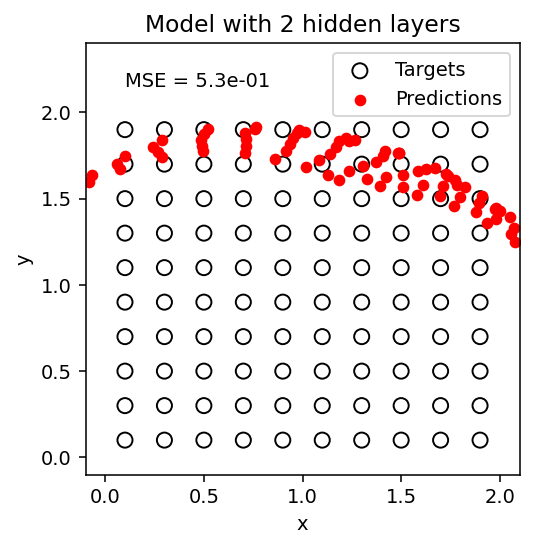

In [259]:
# YOUR CODE GOES HERE
# model 4 (hidden_layer_sizes=[48,48], max_angle=touch.pi/2, lr=0.01, epochs=1000, gamma=0.995)
model4 = InverseArm(hidden_layer_sizes=[48,48], max_angle=torch.tensor(np.pi/2))
train(model4, X_train, X_val, lr=0.01, epochs=1000, gamma=0.995, create_plot=True)
plot_predictions(model4, title=f"Model with {len(model4.hidden_layers)} hidden layers")

# model 5 (hidden_layer_sizes=[48,48], max_angle=None, lr=1, epochs=1000, gamma=1)
model5 = InverseArm(hidden_layer_sizes=[48,48], max_angle=None)
train(model5, X_train, X_val, lr=1, epochs=1000, gamma=1, create_plot=True)
plot_predictions(model5, title=f"Model with {len(model5.hidden_layers)} hidden layers")

# model 6 (hidden_layer_sizes=[48,48], max_angle=2, lr=0.0001, epochs=300, gamma=1)
model6 = InverseArm(hidden_layer_sizes=[48,48], max_angle=2)
train(model6, X_train, X_val, lr=0.0001, epochs=300, gamma=1, create_plot=True)
plot_predictions(model6, title=f"Model with {len(model6.hidden_layers)} hidden layers")

# # show the loss curves and predictions for each model
# for model in [model4, model5, model6]:
#     plot_predictions(model, title= f"Model with {len(model.hidden_layers)} hidden layers")

## Prompts

None of these 3 models should have great performance.
Describe what went wrong in each case.

Model 4 (hidden_layer_sizes=[48,48], max_angle=touch.pi/2, lr=0.01, epochs=1000, gamma=0.995)

    The max_angle limits the output range of my training network to [-π/2, π/2]. This restriction in the range can result in incorrect prediction.

Model 5 (hidden_layer_sizes=[48,48], max_angle=None, lr=1, epochs=1000, gamma=1)

    The learning rate in this case is too large. This can cause the optimizer to overshoot and instability during training. The above can all lead to incorrect predictions.

Model 6 (hidden_layer_sizes=[48,48], max_angle=2, lr=0.0001, epochs=300, gamma=1)

    The number of epochs in this model is too small for proper training output. The small epochs can lead to incomplete optimization and underfitting of the data. The training results can be suboptimal.